In [84]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. 두 CSV 불러오기
df_size = pd.read_csv('seoul_car_registration_2022_2024.csv', encoding='utf-8-sig')
df_fuel  = pd.read_csv('seoul_fuel_passenger_2022_2024.csv', encoding='utf-8-sig')

plt.rcParams['font.family'] = 'Malgun Gothic'   # 윈도우
plt.rcParams['axes.unicode_minus'] = False

In [85]:
# 2. 연도별 총 승용차 계산
total_per_year = df_size.groupby('연도')['승용'].sum().reset_index()
total_per_year.columns = ['연도', '총_승용']

In [86]:
# 3. 병합
merged = pd.merge(total_per_year, df_fuel, on='연도')

In [87]:
# 4. 상관관계 계산 & 출력
corr = merged[['총_승용', '전기_승용', '하이브리드_승용', '수소_승용']].corr()
print("상관관계 행렬:")
print(corr.round(4))

상관관계 행렬:
            총_승용   전기_승용  하이브리드_승용   수소_승용
총_승용      1.0000  0.8434    0.7789  0.9708
전기_승용     0.8434  1.0000    0.9939  0.9477
하이브리드_승용  0.7789  0.9939    1.0000  0.9067
수소_승용     0.9708  0.9477    0.9067  1.0000


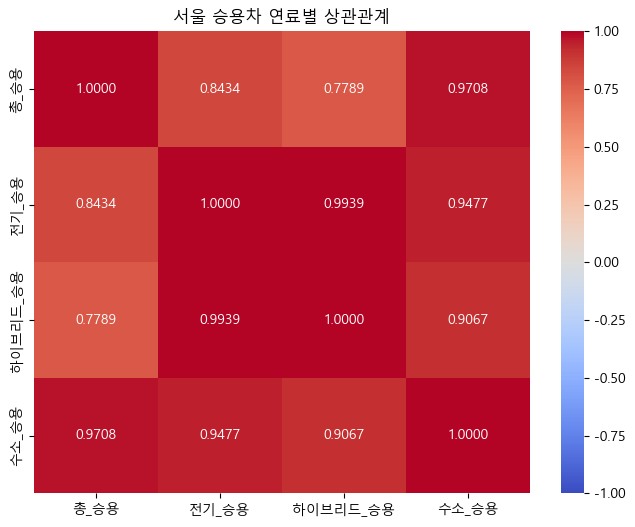

In [88]:
# 히트맵
import seaborn as sns

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.4f')
plt.title('서울 승용차 연료별 상관관계')
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
plt.show()

In [89]:
from scipy import stats

In [90]:
# 1. CSV 파일 읽기
charger_df = pd.read_csv('202412년_지역별_전기차_충전기_구축현황(누적)전처리.csv')
ev_df = pd.read_csv('seoul_fuel_passenger_2022_2024.csv')

In [91]:
# 2. 데이터 확인
print("충전기 누적 데이터:")
print(charger_df)
print("\n전기차 등록 데이터:")
print(ev_df[['연도', '전기_승용']])

충전기 누적 데이터:
     연도  서울_누적_충전기_합계
0  2022         34091
1  2023         48559
2  2024         60201

전기차 등록 데이터:
     연도  전기_승용
0  2022  48914
1  2023  60154
2  2024  70021


In [92]:
# 3. 필요한 열만 추출하고 병합
# 충전기: 연도, 서울_누적_충전기_합계
# 전기차: 연도, 전기_승용 (승용 전기차만 사용)
df = pd.merge(
    charger_df[['연도', '서울_누적_충전기_합계']],
    ev_df[['연도', '전기_승용']],
    on='연도'
)

# 컬럼명 변경
df.rename(columns={
    '서울_누적_충전기_합계': '누적_충전기',
    '전기_승용': '누적_전기차'
}, inplace=True)

df.set_index('연도', inplace=True)

print("\n병합된 누적 데이터:")
print(df)


병합된 누적 데이터:
      누적_충전기  누적_전기차
연도                  
2022   34091   48914
2023   48559   60154
2024   60201   70021


In [93]:
# 4. 상관 분석
correlation = df['누적_충전기'].corr(df['누적_전기차'])
print(f"\nPearson 상관계수: {correlation:.6f}")


Pearson 상관계수: 0.999691


In [94]:
# 5. 선형 회귀 분석
slope, intercept, r_value, p_value, std_err = stats.linregress(
    df['누적_충전기'], df['누적_전기차']
)

print(f"\n선형 회귀 결과 (누적 기준)")
print(f"기울기 (slope): {slope:.4f}")
print(f"  → 충전기 1대당 평균 전기차: 약 {slope:.2f}대")
print(f"R-squared: {r_value**2:.6f}")
print(f"p-value: {p_value:.6f}")


선형 회귀 결과 (누적 기준)
기울기 (slope): 0.8071
  → 충전기 1대당 평균 전기차: 약 0.81대
R-squared: 0.999382
p-value: 0.015832


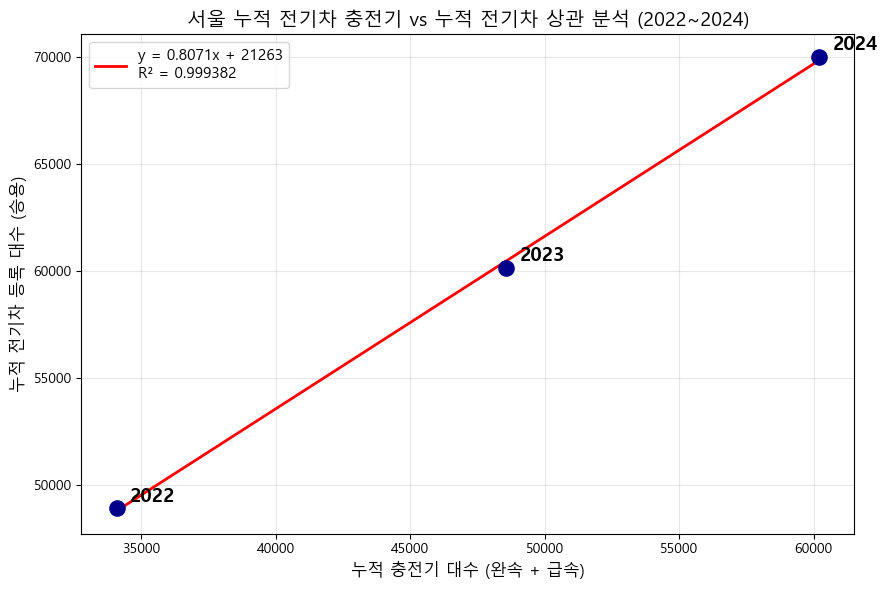

In [95]:
# 6. 시각화
plt.figure(figsize=(9, 6))
plt.scatter(df['누적_충전기'], df['누적_전기차'], color='darkblue', s=120, zorder=5)

# 회귀선 그리기
x_line = df['누적_충전기']
y_line = slope * x_line + intercept
plt.plot(x_line, y_line, color='red', linewidth=2, 
         label=f'y = {slope:.4f}x + {intercept:.0f}\nR² = {r_value**2:.6f}')

# 각 포인트에 연도 라벨
for year, row in df.iterrows():
    plt.text(row['누적_충전기'] + 500, row['누적_전기차'] + 300, 
             str(year), fontsize=14, fontweight='bold')

plt.xlabel('누적 충전기 대수 (완속 + 급속)', fontsize=12)
plt.ylabel('누적 전기차 등록 대수 (승용)', fontsize=12)
plt.title('서울 누적 전기차 충전기 vs 누적 전기차 상관 분석 (2022~2024)', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [96]:
from scipy.stats import linregress, pearsonr
import numpy as np

# 데이터 로드
car_reg = pd.read_csv('seoul_car_registration_2022_2024.csv')
fuel_reg = pd.read_csv('seoul_fuel_passenger_2022_2024.csv')

# 전체 승용차 연도별 합계 계산 (누적 대수)
total_cars = car_reg.groupby('연도')['승용'].sum().reset_index()
total_cars.columns = ['연도', '누적_전체_승용차']

# 전기 승용차 데이터
ev_cars = fuel_reg[['연도', '전기_승용']].copy()
ev_cars.columns = ['연도', '누적_전기_승용차']

# 병합 (3개 포인트)
df = pd.merge(total_cars, ev_cars, on='연도')
df = df.sort_values('연도').reset_index(drop=True)

print("누적 데이터 (3개 포인트):")
print(df)
print("\n")



누적 데이터 (3개 포인트):
     연도  누적_전체_승용차  누적_전기_승용차
0  2022    2761701      48914
1  2023    2775702      60154
2  2024    2774447      70021




In [97]:
# 1. Pearson 상관계수 계산
corr_coeff, corr_p = pearsonr(df['누적_전기_승용차'], df['누적_전체_승용차'])
print(f"Pearson 상관계수: {corr_coeff:.4f} (p-value: {corr_p:.4f})")

Pearson 상관계수: 0.8434 (p-value: 0.3611)


In [98]:
# 2. 선형 회귀 분석 (누적 전체 = 기울기 × 누적 전기 + 절편)
slope, intercept, r_value, p_value, std_err = linregress(
    df['누적_전기_승용차'], df['누적_전체_승용차']
)

print(f"\n선형 회귀 결과 (누적 기준, 3포인트)")
print(f"기울기 (slope): {slope:.4f}")
print(f"  → 누적 전기 승용차 1대 증가 시 누적 전체 승용차 약 {slope:.2f}대 증가")
print(f"절편 (intercept): {intercept:.0f}")
print(f"R-squared: {r_value**2:.4f}")
print(f"p-value: {p_value:.4f}")


선형 회귀 결과 (누적 기준, 3포인트)
기울기 (slope): 0.6187
  → 누적 전기 승용차 1대 증가 시 누적 전체 승용차 약 0.62대 증가
절편 (intercept): 2733684
R-squared: 0.7114
p-value: 0.3611


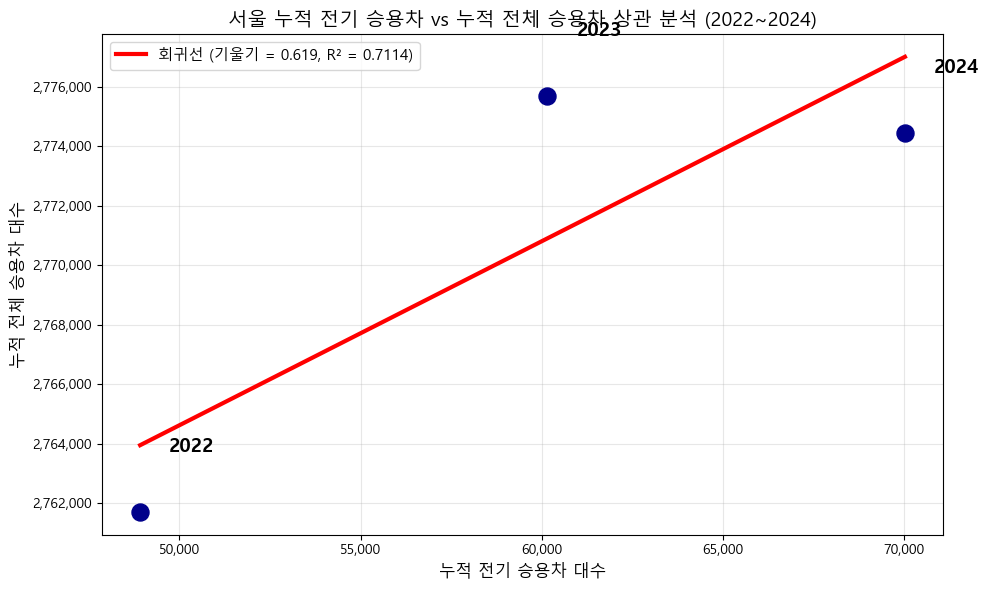

In [99]:
# 3. 시각화: 산점도 + 회귀선
plt.figure(figsize=(10, 6))
plt.scatter(df['누적_전기_승용차'], df['누적_전체_승용차'], 
            color='darkblue', s=150, zorder=5)

# 회귀선
x_line = np.array([df['누적_전기_승용차'].min(), df['누적_전기_승용차'].max()])
y_line = slope * x_line + intercept
plt.plot(x_line, y_line, color='red', linewidth=3, 
         label=f'회귀선 (기울기 = {slope:.3f}, R² = {r_value**2:.4f})')

# 각 포인트에 연도 라벨
for i, row in df.iterrows():
    plt.text(row['누적_전기_승용차'] + 800, row['누적_전체_승용차'] + 2000, 
             str(row['연도']), fontsize=14, fontweight='bold')

plt.xlabel('누적 전기 승용차 대수', fontsize=12)
plt.ylabel('누적 전체 승용차 대수', fontsize=12)
plt.title('서울 누적 전기 승용차 vs 누적 전체 승용차 상관 분석 (2022~2024)', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

# y축 천단위 콤마
plt.gca().yaxis.set_major_formatter(
    plt.FuncFormatter(lambda x, p: f'{int(x):,}')
)
plt.gca().xaxis.set_major_formatter(
    plt.FuncFormatter(lambda x, p: f'{int(x):,}')
)

plt.tight_layout()
plt.show()

=== 최근 12개월 증가율 비교 (단위: %) ===
            전기차_증가율  전체_증가율
날짜                         
2024-12-01     1.41    0.01
2025-01-01    -0.38    0.02
2025-02-01     0.74   -0.05
2025-03-01     1.60    0.03
2025-04-01     1.21   -0.02
2025-05-01     2.60   -0.03
2025-06-01     2.46    0.05
2025-07-01     1.61   -0.06
2025-08-01     2.56   -0.03
2025-09-01     2.78   -0.02
2025-10-01     1.67   -0.07
2025-11-01     2.94    0.01

전기차 증가율 vs 전체 승용차 증가율 상관계수: 0.3019
p-value: 0.0827
(양의 상관 → 둘 다 같이 증가/감소하는 경향, 음의 상관 → 반대로 움직임)


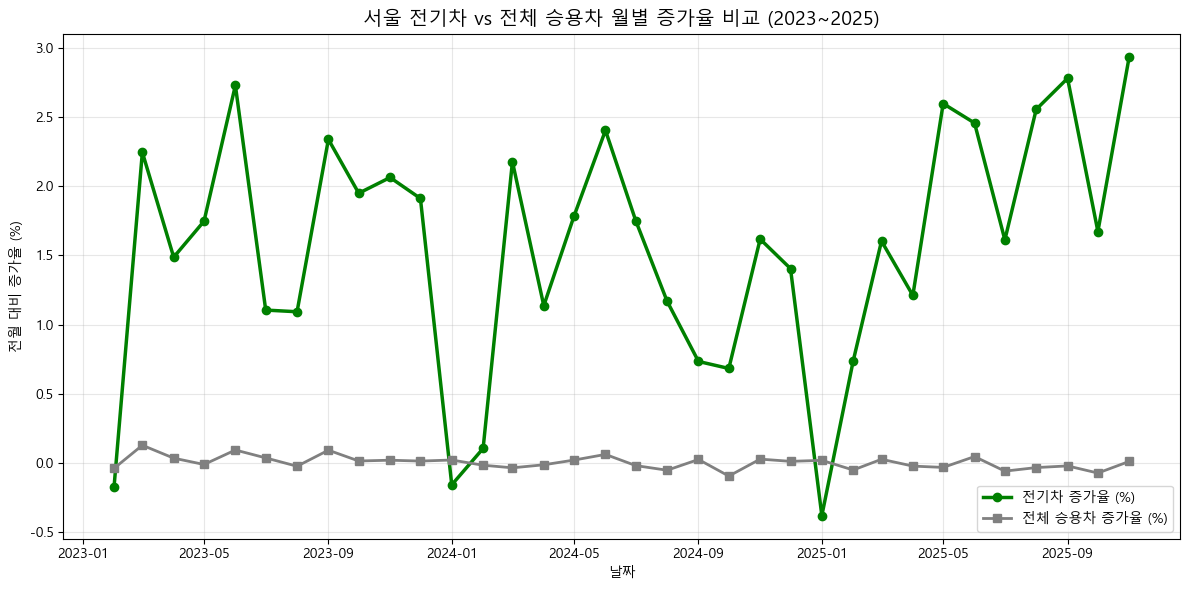

In [100]:
# 1. 데이터 로드
ev_file = '전기차_등록자료_통계_통합.xlsx'
total_file = '자동차_등록자료_통계_통합.xlsx'

ev_df = pd.read_excel(ev_file, sheet_name='서울_승용차_합계')
ev_df.columns = ['연월', '전기차_등록']
total_df = pd.read_excel(total_file, sheet_name='서울_승용차_합계')
total_df.columns = ['연월', '전체_승용차_등록']

# 2. 연월을 문자열 → 숫자 → datetime 변환 (202501 → 2025-01-01)
def parse_ym(ym):
    ym_str = str(int(ym))
    year = ym_str[:4]
    month = ym_str[4:]
    return pd.to_datetime(f"{year}-{month}-01")

ev_df['날짜'] = ev_df['연월'].apply(parse_ym)
total_df['날짜'] = total_df['연월'].apply(parse_ym)

# 3. 날짜 기준 정렬 & 병합
ev_df = ev_df.sort_values('날짜').set_index('날짜')
total_df = total_df.sort_values('날짜').set_index('날짜')

merged = pd.concat([ev_df['전기차_등록'], total_df['전체_승용차_등록']], axis=1).dropna()

# 4. 전월 대비 증가율(%) 계산
merged['전기차_증가율'] = merged['전기차_등록'].pct_change() * 100
merged['전체_증가율'] = merged['전체_승용차_등록'].pct_change() * 100

# NaN (첫 행) 제거
merged = merged.dropna()

# 5. 결과 출력
print("=== 최근 12개월 증가율 비교 (단위: %) ===")
print(merged[['전기차_증가율', '전체_증가율']].tail(12).round(2))

# 6. 두 증가율의 상관관계
corr, pval = pearsonr(merged['전기차_증가율'], merged['전체_증가율'])
print(f"\n전기차 증가율 vs 전체 승용차 증가율 상관계수: {corr:.4f}")
print(f"p-value: {pval:.4f}")
print("(양의 상관 → 둘 다 같이 증가/감소하는 경향, 음의 상관 → 반대로 움직임)")

# 7. 시각화
plt.figure(figsize=(12, 6))
plt.plot(merged.index, merged['전기차_증가율'], label='전기차 증가율 (%)', color='green', linewidth=2.5, marker='o')
plt.plot(merged.index, merged['전체_증가율'], label='전체 승용차 증가율 (%)', color='gray', linewidth=2, marker='s')
plt.title('서울 전기차 vs 전체 승용차 월별 증가율 비교 (2023~2025)', fontsize=14)
plt.xlabel('날짜')
plt.ylabel('전월 대비 증가율 (%)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [101]:
import pandas as pd
import pymysql
import matplotlib.pyplot as plt

# 1. MySQL 데이터베이스 연결
conn = pymysql.connect(
    host='localhost',
    user='root',
    password='12341234',
    db='car_dashboard',
    charset='utf8'
)

# 전기차 데이터 가져오기
df_ev = pd.read_sql("SELECT * FROM seoul_ev_monthly", conn)
df_total = pd.read_sql("SELECT * FROM seoul_car_total_monthly", conn)

# 연결 끊기
conn.close()

C:\Users\User\AppData\Local\Temp\ipykernel_22452\587342198.py:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_ev = pd.read_sql("SELECT * FROM seoul_ev_monthly", conn)
C:\Users\User\AppData\Local\Temp\ipykernel_22452\587342198.py:16: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_total = pd.read_sql("SELECT * FROM seoul_car_total_monthly", conn)


In [102]:
# 2. 연월을 날짜로 바꾸기 (202511 → 2025-11-01)
df_ev['연월'] = pd.to_datetime(df_ev['연월'], format='%Y%m')
df_total['연월'] = pd.to_datetime(df_total['연월'], format='%Y%m')


In [103]:
# 3. 두 데이터를 합치기
df = pd.merge(df_ev[['연월', '등록대수']],
              df_total[['연월', '등록대수']],
              on='연월',
              suffixes=('_전기차', '_전체'))

In [104]:
# 4. 전기차 비율 계산
df['전기차_비율'] = (df['등록대수_전기차'] / df['등록대수_전체']) * 100

In [105]:
# 5. 출력
print("최근 5개월 데이터")
print(df.tail(5))

print("\n전체 평균 전기차 비율:", df['전기차_비율'].mean().round(2), "%")

최근 5개월 데이터
           연월  등록대수_전기차  등록대수_전체    전기차_비율
30 2025-07-01     78270  2773024  2.822550
31 2025-08-01     80270  2772133  2.895604
32 2025-09-01     82501  2771577  2.976681
33 2025-10-01     83881  2769593  3.028640
34 2025-11-01     86344  2769940  3.117179

전체 평균 전기차 비율: 2.57 %


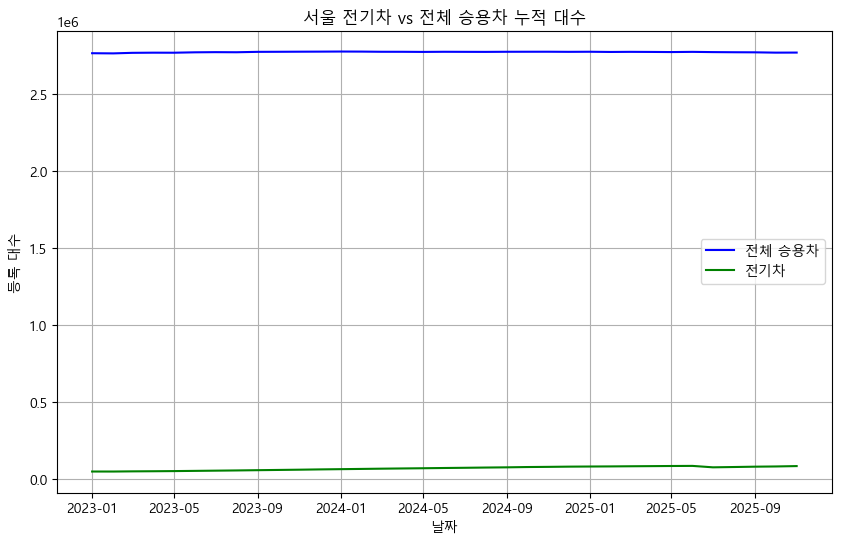

In [106]:
# 6. 그래프
plt.figure(figsize=(10, 6))

# 전체 승용차 (파란색)
plt.plot(df['연월'], df['등록대수_전체'], label='전체 승용차', color='blue')

# 전기차 (초록색)
plt.plot(df['연월'], df['등록대수_전기차'], label='전기차', color='green')

plt.title('서울 전기차 vs 전체 승용차 누적 대수')
plt.xlabel('날짜')
plt.ylabel('등록 대수')
plt.legend()
plt.grid(True)
plt.show()

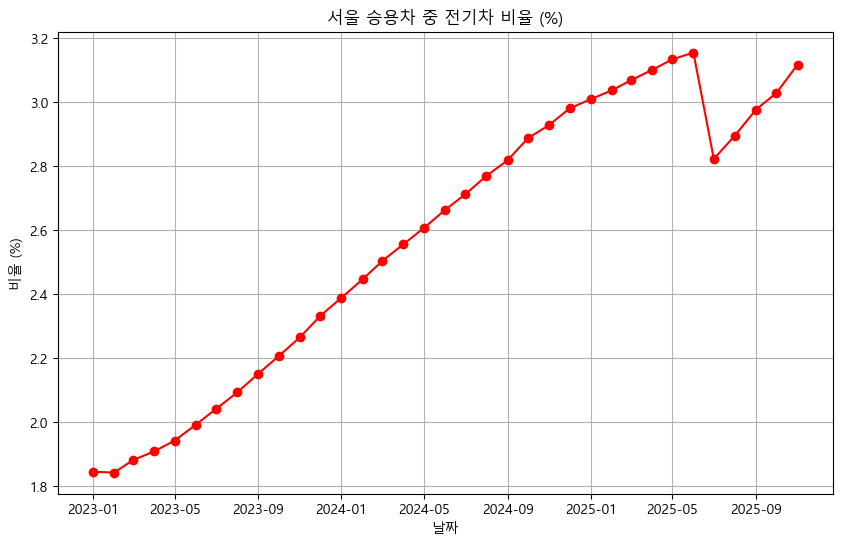

In [107]:
# 7. 전기차 비율만 따로 그래프
plt.figure(figsize=(10, 6))
plt.plot(df['연월'], df['전기차_비율'], color='red', marker='o')
plt.title('서울 승용차 중 전기차 비율 (%)')
plt.xlabel('날짜')
plt.ylabel('비율 (%)')
plt.grid(True)
plt.show()

In [108]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [109]:
# 월 번호 생성
df['월_번호'] = range(1, len(df) + 1)

# 데이터 스무딩 (변동 완화, window=3)
df['smoothed_ev'] = df['등록대수_전기차'].rolling(window=3, min_periods=1).mean()

# X, y: 스무딩 데이터 사용
X = df[['월_번호']].values
y = df['smoothed_ev'].values

# train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

# 선형 회귀 모델
model = LinearRegression()
model.fit(X_train, y_train)


,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


In [110]:
# 모델 성능
r2 = model.score(X_test, y_test)
print(f"\n모델 R² 점수 (테스트 데이터): {r2:.4f}")

# 전체 데이터 재학습
model.fit(X, y)


모델 R² 점수 (테스트 데이터): -18.0712


,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


In [111]:
# 미래 24개월 예측
last_month = df['월_번호'].max()
future_months = np.arange(last_month + 1, last_month + 25).reshape(-1, 1)
future_pred = model.predict(future_months).astype(int)

# 미래 날짜
future_dates = pd.date_range(start=df['연월'].iloc[-1] + pd.DateOffset(months=1), periods=24, freq='MS')

# 예측 결과 출력
print("\n2026~2027년 월별 전기차 누적 예측:")
for date, pred in zip(future_dates, future_pred):
    print(f"{date.strftime('%Y-%m')}: {pred:,}대")

print(f"\n2027년 12월 예상 누적: {future_pred[-1]:,}대")


2026~2027년 월별 전기차 누적 예측:
2025-12: 91,566대
2026-01: 92,741대
2026-02: 93,916대
2026-03: 95,091대
2026-04: 96,266대
2026-05: 97,441대
2026-06: 98,616대
2026-07: 99,790대
2026-08: 100,965대
2026-09: 102,140대
2026-10: 103,315대
2026-11: 104,490대
2026-12: 105,665대
2027-01: 106,840대
2027-02: 108,015대
2027-03: 109,190대
2027-04: 110,364대
2027-05: 111,539대
2027-06: 112,714대
2027-07: 113,889대
2027-08: 115,064대
2027-09: 116,239대
2027-10: 117,414대
2027-11: 118,589대

2027년 12월 예상 누적: 118,589대


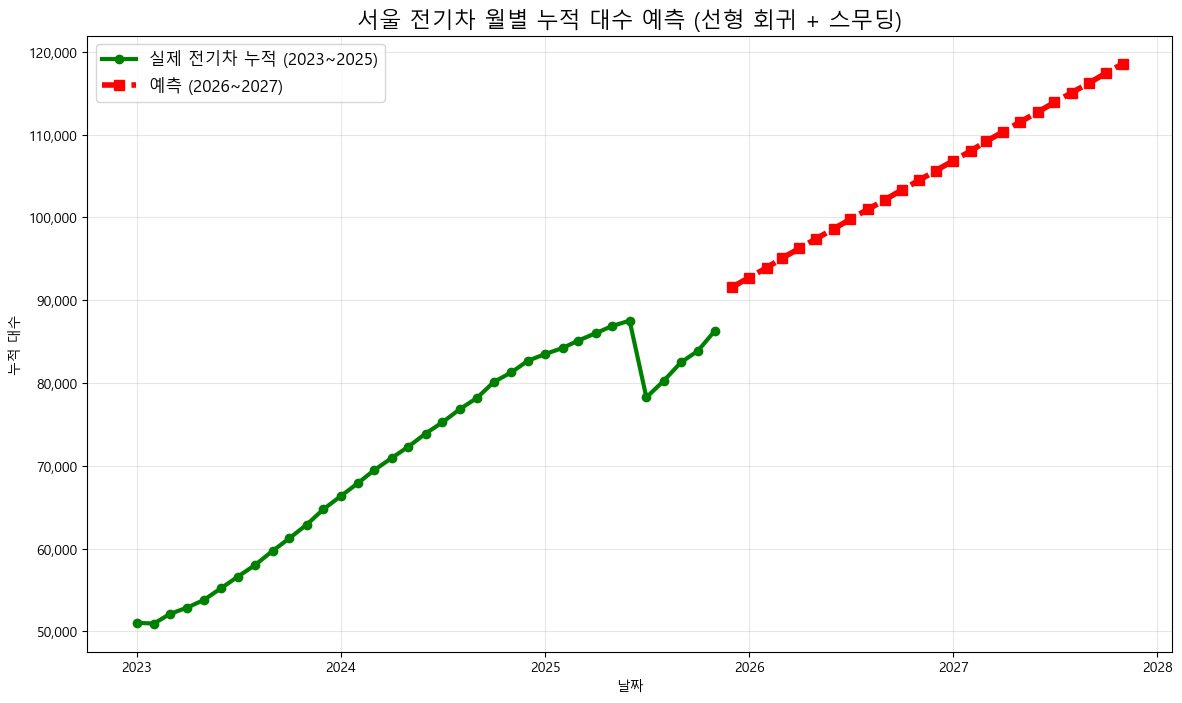

In [112]:
# 실제 + 예측 그래프 (우상향)
plt.figure(figsize=(14, 8))
plt.plot(df['연월'], df['등록대수_전기차'], 'o-', color='green', linewidth=3, markersize=6, label='실제 전기차 누적 (2023~2025)')
plt.plot(future_dates, future_pred, 's--', color='red', linewidth=4, markersize=7, label='예측 (2026~2027)')
plt.title('서울 전기차 월별 누적 대수 예측 (선형 회귀 + 스무딩)', fontsize=16)
plt.xlabel('날짜')
plt.ylabel('누적 대수')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.show()

In [113]:
file = '전기차비중.xlsx'
df = pd.read_excel(file, sheet_name='Sheet1', header=0)
df.columns = ['연월', '전체', '전기차', '전기차비중']  # 열 이름 설정

# 상관분석 (전기차 등록 vs 전기차 비중)
corr, p_value = pearsonr(df['전기차'], df['전기차비중'])

print(f"상관계수: {corr:.4f}")
print(f"p-value: {p_value:.4f}")

ValueError: Length mismatch: Expected axis has 5 elements, new values have 4 elements

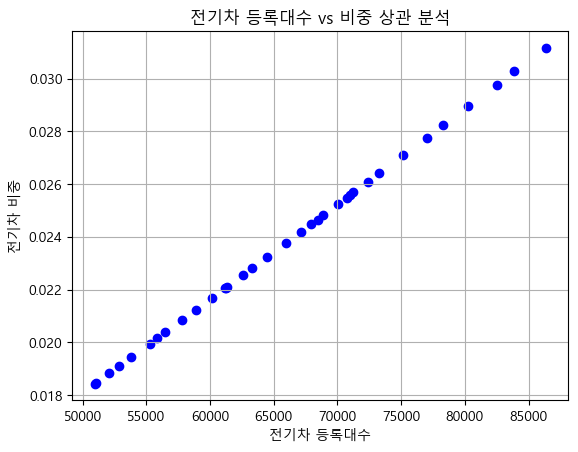

In [ ]:
# 시각화
plt.scatter(df['전기차'], df['전기차비중'], color='blue')
plt.title('전기차 등록대수 vs 비중 상관 분석')
plt.xlabel('전기차 등록대수')
plt.ylabel('전기차 비중')
plt.grid(True)
plt.show()

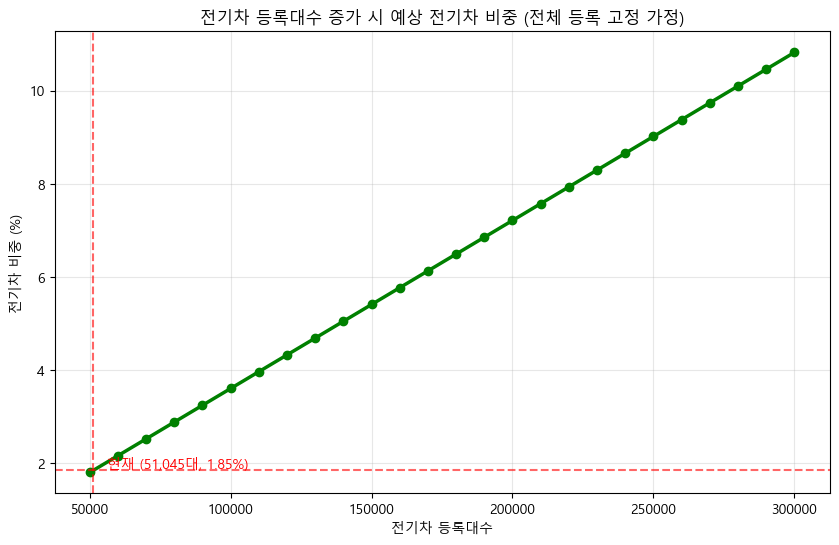

In [ ]:
# 현재 평균 전체 등록대수
avg_total = df['전체'].mean()  # ≈ 2,770,000대

# 가상 시나리오: 전기차가 5만~30만대까지 증가했을 때 비중
future_ev = np.arange(50000, 300001, 10000)
future_ratio = future_ev / avg_total * 100

plt.figure(figsize=(10, 6))
plt.plot(future_ev, future_ratio, 'o-', color='green', linewidth=2.5)
plt.title('전기차 등록대수 증가 시 예상 전기차 비중 (전체 등록 고정 가정)')
plt.xlabel('전기차 등록대수')
plt.ylabel('전기차 비중 (%)')
plt.grid(True, alpha=0.3)

# 현재 실제 비중 표시
current_ev = df['전기차'].iloc[-1]
current_ratio = df['전기차비중'].iloc[-1] * 100
plt.axvline(current_ev, color='red', linestyle='--', alpha=0.6)
plt.axhline(current_ratio, color='red', linestyle='--', alpha=0.6)
plt.text(current_ev + 5000, current_ratio + 0.05, 
         f'현재 ({current_ev:,}대, {current_ratio:.2f}%)', color='red')

plt.show()

In [ ]:
data = {
    '전기차': [51045, 50957, 52101, 52876, 53800, 55268, 55879, 56490, 57811, 58938, 
               60154, 61304, 61208, 61273, 62607, 63319, 64450, 65999, 67154, 67939,
               68438, 68906, 70021, 71005, 70736, 71258, 72401, 73278, 75181, 77028,
               78270, 80270, 82501, 83881, 86344],
    '비중': [0.01846, 0.01843, 0.01882, 0.01909, 0.01943, 0.01994, 0.02015, 0.02038, 
             0.02084, 0.02124, 0.02167, 0.02208, 0.02204, 0.02207, 0.02256, 0.02282,
             0.02322, 0.02376, 0.02418, 0.02448, 0.02465, 0.02484, 0.02524, 0.02559,
             0.02549, 0.02569, 0.02609, 0.02641, 0.02711, 0.02776, 0.02823, 0.02896,
             0.02977, 0.03029, 0.03117]
}

df = pd.DataFrame(data)

# 선형회귀 모델 학습
X = df['전기차'].values.reshape(-1, 1)
y = df['비중'].values * 100  # % 단위

model = LinearRegression()
model.fit(X, y)


,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


In [ ]:
# 플롯 범위 확장 (현재 최대값 → 미래 20만대까지)
x_min = df['전기차'].min()
x_max = 200000  # 2030년 정도까지 충분히 넓게 (필요하면 더 늘려도 됨)

x_range = np.linspace(x_min, x_max, 200)  # 더 부드럽게
y_range = model.predict(x_range.reshape(-1, 1))


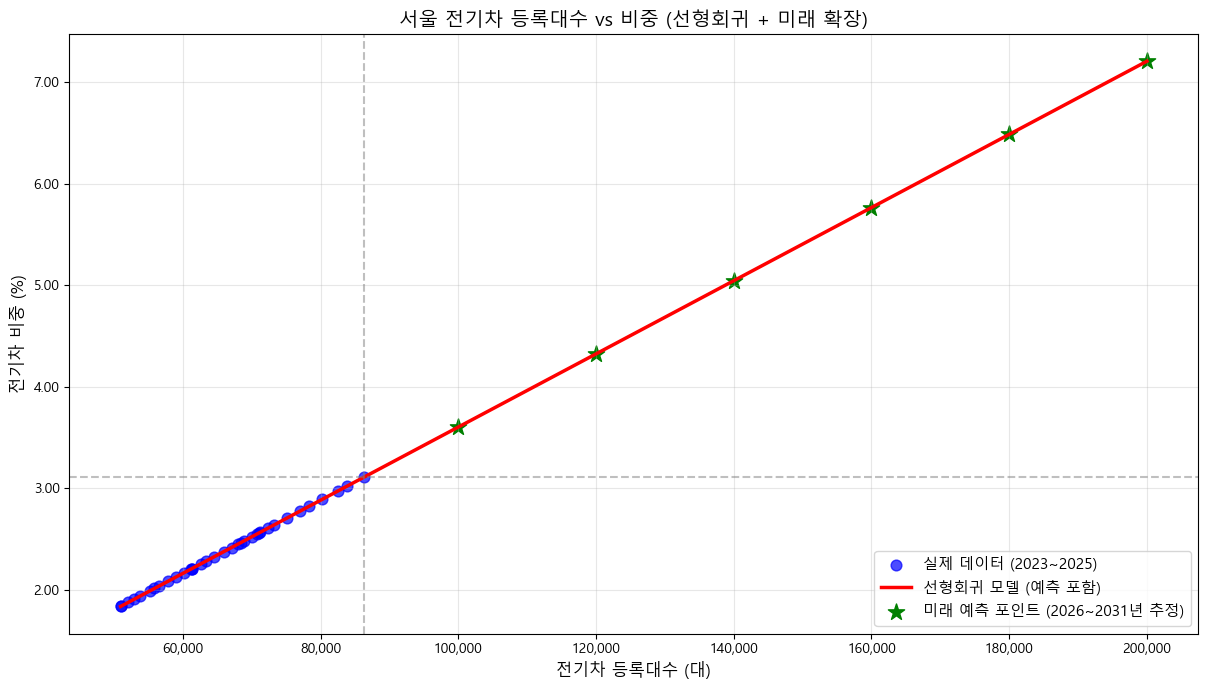

In [ ]:
data = {
    '자치구': ['강남구', '강동구', '강북구', '강서구', '관악구', '광진구', '구로구', '금천구', '노원구', '도봉구',
              '동대문구', '동작구', '마포구', '서대문구', '서초구', '송파구', '영등포구', '용산구', '은평구',
              '종로구', '중구', '중랑구'],
    'CCTV': [890, 140, 111, 164, 751, 78, 315, 195, 158, 114, 287, 66, 235, 421, 1295, 439, 613, 357, 384, 287, 345, 304],
    '사고건수': [3754, 1428, 877, 1538, 1254, 785, 1320, 798, 1288, 522, 1520, 1230, 1201, 818, 2027, 2500, 1948, 868, 1218, 917, 976, 1199]
}

df = pd.DataFrame(data)

# -------------------------------
# 1. 상관분석 (사고건수(x) → CCTV(y))
# -------------------------------
corr, p_value = pearsonr(df['사고건수'], df['CCTV'])
print(f"상관계수: {corr:.4f} (양의 상관 = 사고 많을수록 CCTV도 많음)")
print(f"p-value: {p_value:.4f} (0.05 미만 → 통계적으로 유의)\n")

# -------------------------------
# 2. 선형회귀 모델 학습
# -------------------------------
X = df['사고건수'].values.reshape(-1, 1)   # 독립변수: 사고건수
y = df['CCTV'].values                      # 종속변수: CCTV 개수

model = LinearRegression()
model.fit(X, y)

# 모델 성능
y_pred = model.predict(X)
r2 = r2_score(y, y_pred)
print(f"모델 R²: {r2:.4f} (설명력)")
print(f"회귀식: CCTV = {model.coef_[0]:.3f} × 사고건수 + {model.intercept_:.3f}\n")

# -------------------------------
# 3. 산점도 + 회귀선
# -------------------------------
plt.figure(figsize=(10, 6))
plt.scatter(df['사고건수'], df['CCTV'], color='darkorange', s=100, alpha=0.8, label='실제 데이터 (2025 자치구별)')

x_range = np.linspace(df['사고건수'].min(), df['사고건수'].max(), 100)
y_range = model.predict(x_range.reshape(-1, 1))
plt.plot(x_range, y_range, color='blue', linewidth=3, label='선형회귀 모델')

plt.title('서울 자치구별 사고건수 vs CCTV 개수 (2025년)', fontsize=14)
plt.xlabel('사고건수')
plt.ylabel('CCTV 개수')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# -------------------------------
# 4. 미래/가상 예측 함수
# -------------------------------
def predict_cctv(accidents):
    """사고건수 입력 → 예상 CCTV 개수 반환"""
    return round(model.predict([[accidents]])[0]).astype(int)

# 예시 예측
print("예상 CCTV 설치량 (사고건수 입력 시):")
accident_examples = [500, 1000, 1500, 2000, 2500, 3000]
for acc in accident_examples:
    predicted_cctv = predict_cctv(acc)
    print(f"사고 {acc}건 → 예상 CCTV: {predicted_cctv}대")

# 사용 예시
# new_accidents = 1800  # 예: 특정 자치구 미래 사고건수
# print(f"예상 CCTV: {predict_cctv(new_accidents)}대")

상관계수: 0.6119 (사고 많을수록 CCTV도 많음)
p-value: 0.0025

모델 R²: 0.3744
회귀식: CCTV = 0.258 × 사고건수 + 9.700

예상 CCTV 설치량:
사고 500건 → 예상 CCTV: 139대
사고 1000건 → 예상 CCTV: 268대
사고 1500건 → 예상 CCTV: 397대
사고 2000건 → 예상 CCTV: 526대
사고 2500건 → 예상 CCTV: 655대
사고 3000건 → 예상 CCTV: 784대


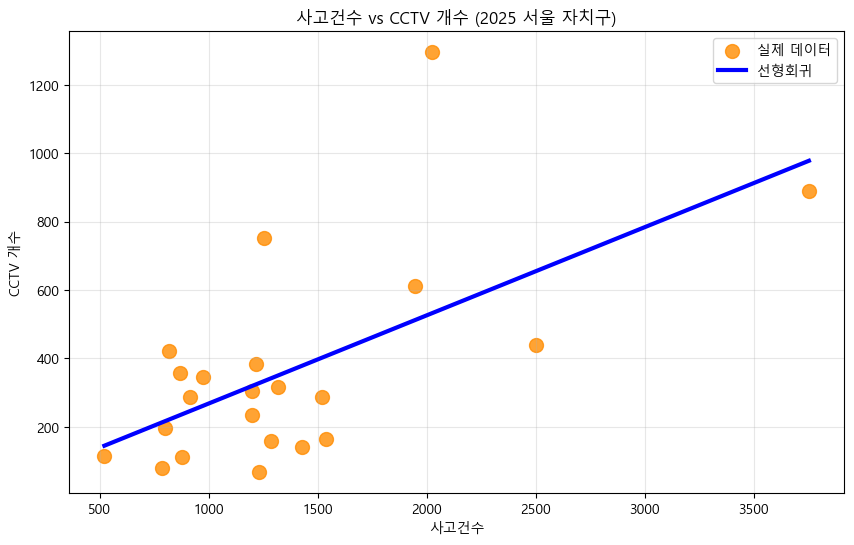

In [ ]:
from sklearn.metrics import r2_score

data = {
    '자치구': ['강남구', '강동구', '강북구', '강서구', '관악구', '광진구', '구로구', '금천구', '노원구', '도봉구',
              '동대문구', '동작구', '마포구', '서대문구', '서초구', '송파구', '영등포구', '용산구', '은평구',
              '종로구', '중구', '중랑구'],
    'CCTV': [890, 140, 111, 164, 751, 78, 315, 195, 158, 114, 287, 66, 235, 421, 1295, 439, 613, 357, 384, 287, 345, 304],
    '사고건수': [3754, 1428, 877, 1538, 1254, 785, 1320, 798, 1288, 522, 1520, 1230, 1201, 818, 2027, 2500, 1948, 868, 1218, 917, 976, 1199]
}

df = pd.DataFrame(data)

# 상관분석
corr, p_value = pearsonr(df['사고건수'], df['CCTV'])
print(f"상관계수: {corr:.4f} (사고 많을수록 CCTV도 많음)")
print(f"p-value: {p_value:.4f}\n")

# 선형회귀
X = df['사고건수'].values.reshape(-1, 1)
y = df['CCTV'].values

model = LinearRegression()
model.fit(X, y)

y_pred = model.predict(X)
r2 = r2_score(y, y_pred)
print(f"모델 R²: {r2:.4f}")
print(f"회귀식: CCTV = {model.coef_[0]:.3f} × 사고건수 + {model.intercept_:.3f}\n")

# 예측 함수 (오류 수정 완료)
def predict_cctv(accidents):
    """사고건수 입력 → 예상 CCTV 개수 반환"""
    predicted = model.predict([[accidents]])[0]
    return int(round(predicted))  # 반올림 후 정수 변환

# 예시
print("예상 CCTV 설치량:")
accident_examples = [500, 1000, 1500, 2000, 2500, 3000]
for acc in accident_examples:
    print(f"사고 {acc}건 → 예상 CCTV: {predict_cctv(acc)}대")

# 그래프
plt.figure(figsize=(10, 6))
plt.scatter(df['사고건수'], df['CCTV'], color='darkorange', s=100, alpha=0.8, label='실제 데이터')
x_range = np.linspace(df['사고건수'].min(), df['사고건수'].max(), 100)
y_range = model.predict(x_range.reshape(-1, 1))
plt.plot(x_range, y_range, color='blue', linewidth=3, label='선형회귀')
plt.title('사고건수 vs CCTV 개수 (2025 서울 자치구)')
plt.xlabel('사고건수')
plt.ylabel('CCTV 개수')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()